# PyEAFE

This notebook is a simple example of how the standard **PDE Labs** environment can provide an interactive finite element analysis.
The goal of this notebook is to demonstrate a convergence analysis for $C^0$ linear finite element space with respect to mesh refinement.

The problem being investigated is a standard heat equation with Dirichlet boundary conditions in two dimensions:
\begin{equation}
    -\nabla \cdot (\alpha \nabla(u) + \beta  u) + R u = f
\end{equation}

* $\alpha=$ diffusion
* $\beta=$ convection
* $\gamma=$ reaction
* $f$ is the source term


In [78]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
import pyeafe
import time

from typing import List

import matplotlib.pyplot as plt
from dolfin import *

"""
    Thanks to Chris Richardson for providing the basis for the following
    plotting functions:
        https://fenicsproject.org/qa/5795/plotting-dolfin-solutions-in-matplotlib/
"""

def mesh_to_triangulation(mesh: Mesh) -> tri.Triangulation:
    if (mesh.geometry().dim() != 2):
            raise(AttributeError)

    xy = mesh.coordinates()
    return tri.Triangulation(xy[:, 0], xy[:, 1], mesh.cells())


def plot_mesh(ax, mesh: Mesh):
    ax.set_aspect('equal')
    ax.set_xlabel('mesh')
    ax.triplot(mesh_to_triangulation(mesh), color='k')


def plot_solution(ax, mesh: Mesh, solution: Function):
    ax.set_aspect('equal')
    ax.set_xlabel('computed solution')
    triang: tri.Triangulation = mesh_to_triangulation(mesh)

    if solution.vector().size() == mesh.num_cells():
        solution_array = solution.vector().array()
        ax.tripcolor(triang, solution_array, vmin=0., vmax=1.)

    else:
        solution_array = solution.compute_vertex_values(mesh)
        ax.tripcolor(triang, solution_array, vmin=0., vmax=1., shading='gouraud')
        
        
def plot_error(ax, mesh: Mesh, exact: Function, computed: Function):
    ax.set_aspect('equal')
    ax.set_xlabel('error')
    triang: tri.Triangulation = mesh_to_triangulation(mesh)

    if exact.vector().size() == mesh.num_cells():
        exact_array = exact.vector().array()
        computed_array = computed.vector().array()
        return ax.tripcolor(triang, exact_array - computed_array, cmap='RdBu_r')

    else:
        exact_array = exact.compute_vertex_values(mesh)
        computed_array = computed.compute_vertex_values(mesh)
        return ax.tripcolor(triang, exact_array - computed_array, shading='gouraud', cmap='RdBu_r')

def boundary(x, on_boundary):
    """
    helps dolfin define boundary terms
    """
    return on_boundary
    

def discretize(granularity: int) -> (UnitSquareMesh, FunctionSpace, TrialFunction, TestFunction):
    mesh = UnitSquareMesh(granularity, granularity)
    fe_space = FunctionSpace(mesh, "Lagrange", 1)
    trial_fn = TrialFunction(fe_space)
    test_fn = TestFunction(fe_space)
    
    return mesh, fe_space, trial_fn, test_fn

class ConvergenceDatum(object):
    def __init__(self, granularity, alpha, beta=None, potential=None, eafe=0):
        self.granularity = granularity
        self.computed_solution = compute_solution(granularity, alpha, beta, eafe=eafe)
        self.error = errornorm(exact_solution, self.computed_solution, "H1", 3)

        self._mesh = self.computed_solution.function_space().mesh()
        self._interpolant = interpolate(exact_solution, self.computed_solution.function_space())

    def plot(self):
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(17, 5))
        axs = axs.flatten()
        plot_mesh(axs[0], self._mesh)
        plot_solution(axs[1], self._mesh, self.computed_solution)
        tcp = plot_error(axs[2], self._mesh, self._interpolant, self.computed_solution)

        fig.colorbar(tcp)
        fig.suptitle(f"At granularity {self.granularity}, the H1-error is {self.error:e}.", fontsize=14)
        plt.show()

def compute_solution(granularity: int, alpha, beta=None, Potential=None, eafe=0) -> Function:
    mesh, fe_space, trial_fn, test_fn = discretize(granularity)
    
    # UFL discretization expression
    bc = DirichletBC(fe_space, exact_solution, boundary)
    linear_form = source * test_fn * dx
    solution = Function(fe_space)
    
    if eafe==0:
        bilinear_form = inner(alpha*grad(trial_fn)+beta*trial_fn, grad(test_fn)) * dx
        stiffness_matrix =  assemble(bilinear_form)
    else:
        stiffness_matrix = pyeafe.eafe_assemble(mesh, alpha, beta)
    rhs_vector = assemble(linear_form)
    bc.apply(stiffness_matrix, rhs_vector)

    # linear solver
    solver = LUSolver(stiffness_matrix, "default")
    solver.parameters["symmetric"] = False
    solver.solve(solution.vector(), rhs_vector)
    
    return solution

def plot_convergence_summary(data: List[ConvergenceDatum], expected_order: int = 1):
    log_g: np.array = np.log(np.array([d.granularity for d in data]))
    log_error: np.array = np.log(np.array([d.error for d in data]))
    ref_line: np.array = log_error[-1] + float(expected_order) * (log_g[-1] - log_g)

    plt.plot(log_g, ref_line, 'c--', label='$\mathcal{O}(h^' + f'{expected_order}' + ')$')
    plt.plot(log_g, log_error, 'k', label='$\log(\mathcal{H}^1-\mathrm{error})$')

    plt.title('Convergence plot')
    plt.xlabel('$\log(g)$')
    plt.legend()
    plt.show()

## Example 1

The exact solution is defined by
\begin{equation}
  u(x_0, x_1) = \sin(2\pi x_0) \cos(2\pi x_1).
\end{equation}

In [113]:
exact_solution = Expression(
        "sin(2 * DOLFIN_PI * x[0]) * cos(2 * DOLFIN_PI * x[1])", degree=4
    )
source = Expression(
        "8 * DOLFIN_PI * DOLFIN_PI * diffusivity\
        * sin(2 * DOLFIN_PI * x[0]) * cos(2 * DOLFIN_PI * x[1])\
        - 2 * DOLFIN_PI * x[1] * cos(2 * DOLFIN_PI * x[0])\
        * cos(2 * DOLFIN_PI * x[1])\
        - 2 * DOLFIN_PI * x[0] * sin(2 * DOLFIN_PI * x[0])\
        * sin(2 * DOLFIN_PI * x[1])",
        degree=4,
        diffusivity=1.0e-8,
    )

alpha = Expression("1.e-8", degree=0)
beta = Expression(("x[1]", "-x[0]"), degree=1)

### The finite element formulation

### convergence
Using the convergence data class above, finite element solutions are computed on a sequence of uniformly refined meshes with meshes, computed solutions, and errors plotted for visual inspection. 

#### EAFE

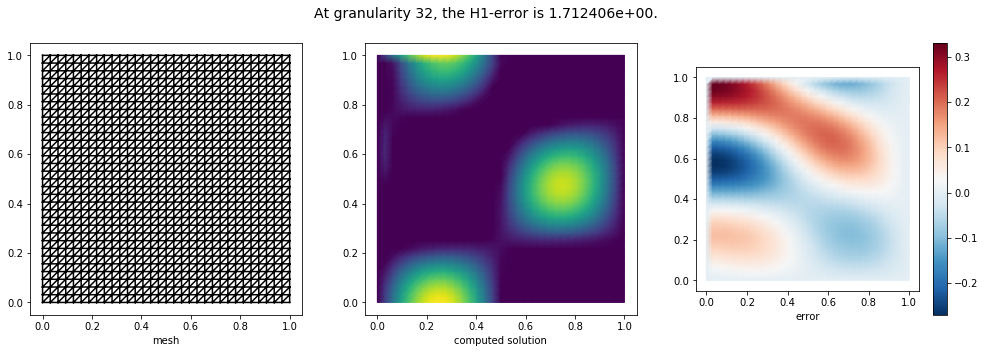

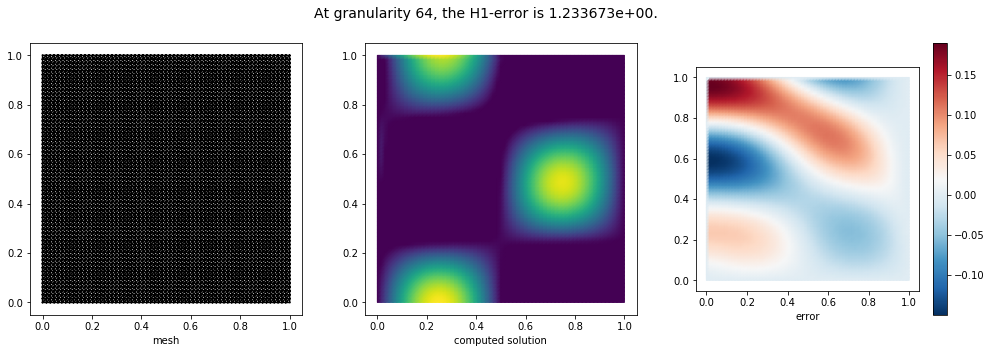

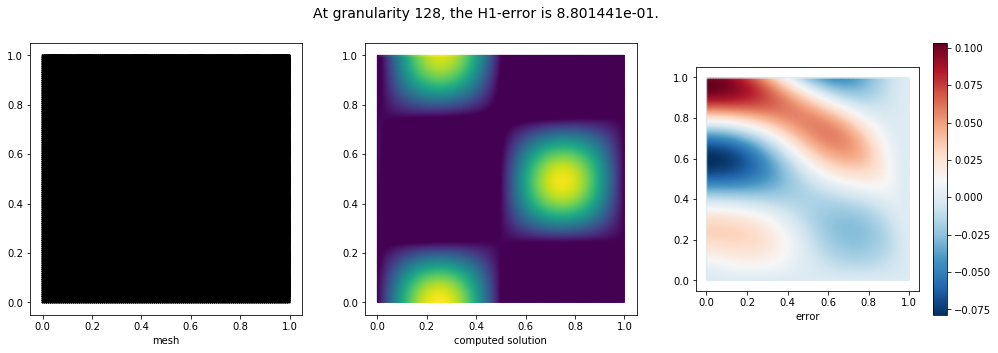

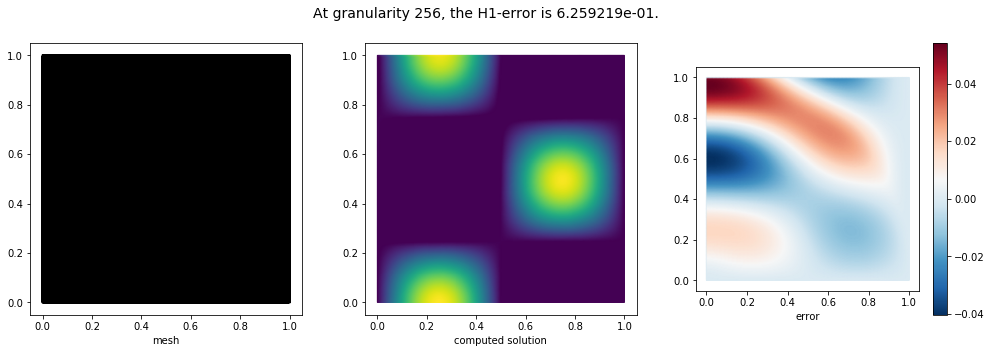

In [114]:
# granularities = [4, 8, 16, 32, 64, 128, 256]
granularities = [32, 64, 128, 256]
convergence_data = [ConvergenceDatum(granularity, alpha, beta=beta,eafe=1) for granularity in granularities]

for datum in convergence_data:
    datum.plot()

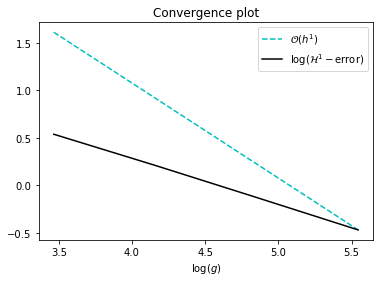

In [115]:
plot_convergence_summary(convergence_data, expected_order=1)

#### NO EAFE

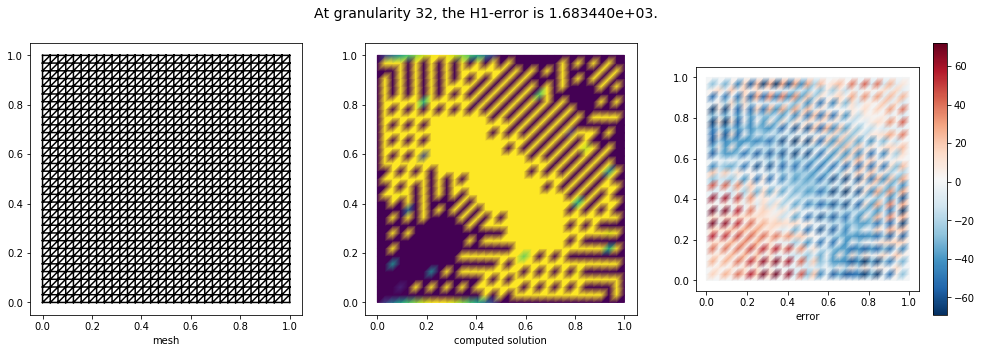

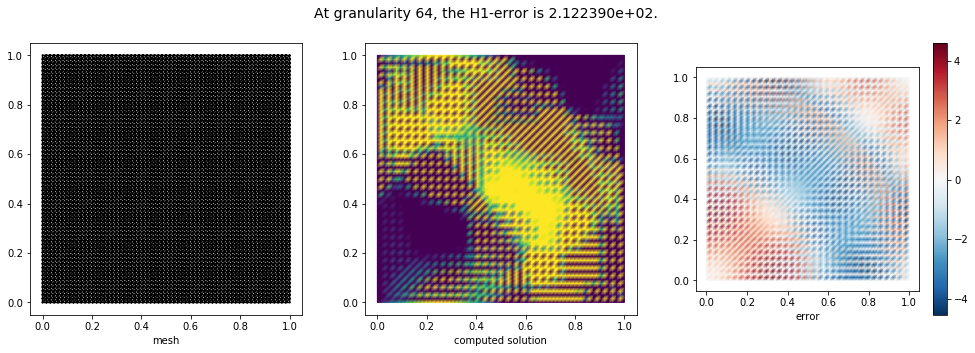

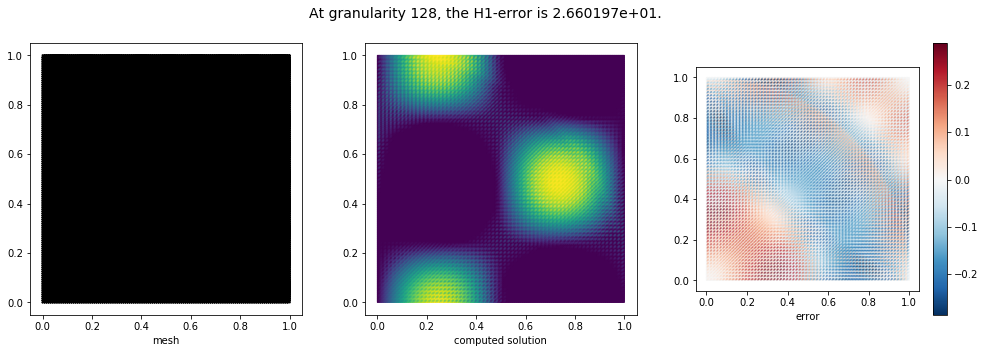

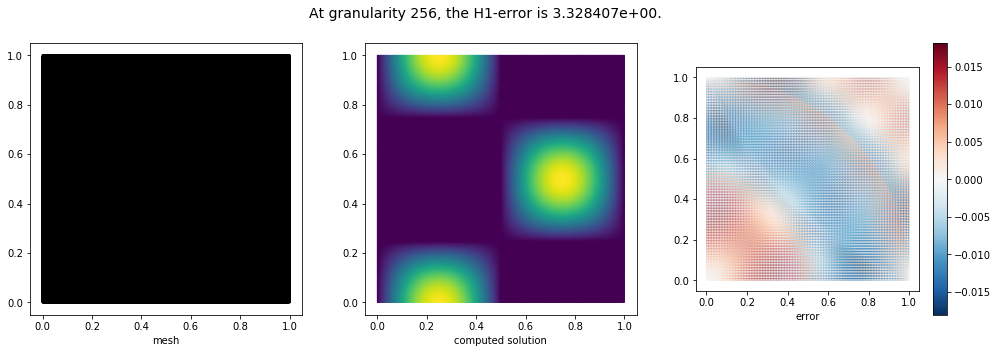

In [116]:
# granularities = [4, 8, 16, 32, 64, 128, 256]
granularities = [32, 64, 128, 256]
convergence_data = [ConvergenceDatum(granularity, alpha, beta=beta, eafe=0) for granularity in granularities]

for datum in convergence_data:
    datum.plot()

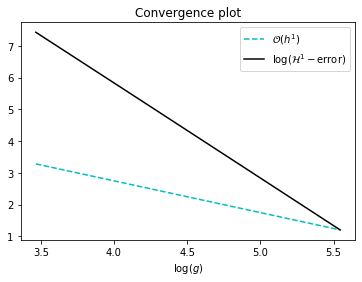

In [117]:
plot_convergence_summary(convergence_data, expected_order=1)

## Example 2

\begin{equation}
    -\nabla \cdot (\varepsilon \nabla(u) + (-y,x)  u) + R u = 1
\end{equation}
$\varepsilon = 10^{-6}$

In [119]:
source = Expression('1.0', degree=0)

alpha = Expression("1.e-3", degree=0)
beta = Expression(("x[1]", "x[0]"), degree=1)

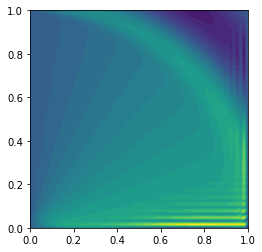

In [120]:
compute_solution(64, alpha, beta=beta, Potential=None, eafe=1)
plot(u)

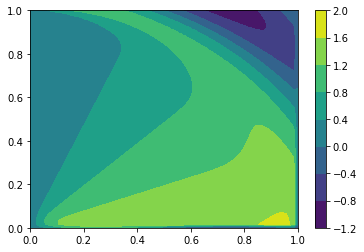

In [101]:
u=compute_solution(64, alpha, beta=beta, Potential=None, eafe=1)
mesh = u.function_space().mesh()
triang = mesh_to_triangulation(mesh)
# solution_array = u.vector().get_local()
solution_array = u.compute_vertex_values(mesh)
plt.figure()
plt.tricontourf(triang, solution_array)
plt.colorbar()
plt.show()

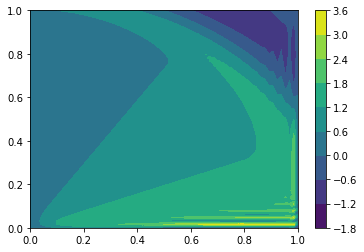

In [102]:
u=compute_solution(64, alpha, beta=beta, Potential=None, eafe=0)
mesh = u.function_space().mesh()
triang = mesh_to_triangulation(mesh)
# solution_array = u.vector().get_local()
solution_array = u.compute_vertex_values(mesh)
plt.figure()
plt.tricontourf(triang, solution_array)
plt.colorbar()
plt.show()

## Example 3

In [166]:
def compute_solution2(granularity: int, alpha, Potential, eafe=0) -> Function:
    mesh, fe_space, trial_fn, test_fn = discretize(granularity)
    
    # UFL discretization expression
    bc = DirichletBC(fe_space, exact_solution, boundary)
    linear_form = source * test_fn * dx
    solution = Function(fe_space)
    
#     fe2_space = FunctionSpace(mesh, "BDM", 1)
#     trial2_fn = TrialFunction(fe_space)
#     test2_fn = TestFunction(fe_space)
#     a = inner(trial2_fn, test2_fn) * dx
#     L = inner(grad(Potential), test2_fn) * dx

#     beta = Function(fe2_space)
#     solve(a == L, beta)
    
    beta = project(grad(Potential), VectorFunctionSpace(mesh, "Lagrange", 1))
    
    if eafe==0:
        bilinear_form = inner(alpha*grad(trial_fn)+beta*trial_fn, grad(test_fn)) * dx
        stiffness_matrix =  assemble(bilinear_form)
    else:
        stiffness_matrix = pyeafe.eafe_assemble(mesh, alpha, beta)
    rhs_vector = assemble(linear_form)
    bc.apply(stiffness_matrix, rhs_vector)

    # linear solver
    solver = LUSolver(stiffness_matrix, "default")
    solver.parameters["symmetric"] = False
    solver.solve(solution.vector(), rhs_vector)
    
    return solution

In [167]:
source = Expression('1.0', degree=0)

alpha = Expression("1.e-3", degree=0)


class Linear_Function(UserExpression):
    def eval(self, value, x):
        value = x[0]*x[1]
    def value_shape(self):
        return (1,)
    
# Potential = Linear_Function()
Potential = Expression("x[0]*x[1]", degree=2, cell=triangle)

In [168]:
compute_solution2(64, alpha, Potential, eafe=0)
plot(u)

Invalid cell None.


UFLException: Invalid cell None.